# Importing Libraries

In [ ]:
import torch
import torchvision
import os
import PIL
import pdb
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.utils import make_grid
from tqdm.auto import tqdm
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [ ]:
def show_tensor_img(tensor, number, name = ''):
  dt = tensor.detach().cpu()
  grid = make_grid(dt[:number], nrow = 4).permute(1,2,0)

  plt.imshow(grid.clip(0,1))
  """
  clip the values of pixels to be between zero and one and show
  so we dont over-saturate anything visually or under saturate
  """
  plt.show()



# Parameters

In [ ]:
epochs = 5000
BATCH_SIZE = 128
lr = 0.001
z_dim = 300
#we are working with complex data so we need more dimensional latent space
device = 'cuda' if torch.cuda.is_available() else 'cpu'

current_step = 0

discriminator_cycles = 5
generator_losses = []
discriminator_losses = []

info_step = 50
save_step = 50

"""
checkpoint of values and parameters of the generator and discriminator. Saving in a file
so we can stop training and restart training any time
"""


'\ncheckpoint of values and parameters of the generator and discriminator. Saving in a file\nso we can stop training and restart training any time\n'

# Model

In [ ]:
class Generator(nn.Module):
  def __init__(self, z_dim = 64, d_dim = 16):
    super(Generator,self).__init__()
    self.z_dim = z_dim

    self.generator = nn.Sequential(

        nn.ConvTranspose2d(z_dim, d_dim*32, 4, 1, 0), #new size 4x4 image(ch:200->512)
        nn.BatchNorm2d(d_dim*32),
        nn.ReLU(True),

        # we begin with little size of image 1x1 with z_dim number of channels but we're gonna
        #go from 200 channels to 512. Calculating new w h: (n-1)*stride - 2*padding + kernel_Size


        nn.ConvTranspose2d(d_dim*32, d_dim*16, 4, 2, 1), #new size 8x8 image(ch:512->256)
        nn.BatchNorm2d(d_dim*16),
        nn.ReLU(True),

        nn.ConvTranspose2d(d_dim*16, d_dim*8, 4, 2, 1), #new size 16x16 image(ch:256->128)
        nn.BatchNorm2d(d_dim*8),
        nn.ReLU(True),

        nn.ConvTranspose2d(d_dim*8, d_dim*4, 4, 2, 1), #new size 32x32 image(ch:128->64)
        nn.BatchNorm2d(d_dim*4),
        nn.ReLU(True),

        nn.ConvTranspose2d(d_dim*4, d_dim*2, 4, 2, 1), #new size 64x64 image(ch:64->32)
        nn.BatchNorm2d(d_dim*2),
        nn.ReLU(True),

        nn.ConvTranspose2d(d_dim*2, 3, 4, 2, 1), #new size 128x128 image(ch:32->3)
        nn.Tanh()  #produce result in the range from -1 to 1

    )

  def forward(self, noise):
    x = noise.view(len(noise), self.z_dim, 1, 1)
     #128x200x1x1 image 1 pixel 300 channels dimensionality of latent space
    return self.generator(x)

## Noise Generator

In [ ]:
def noise_generator(number, z_dim, device = device):
  return torch.randn(number, z_dim, device = device) #128x300

## Discriminator Model

In [ ]:
class Discriminator(nn.Module):
  def __init__(self, d_dim = 16):
    super(Discriminator, self).__init__()

    self.discriminator = nn.Sequential(
        #new w and h: (n+2*pad-ks)//stride + 1
        nn.Conv2d(3, d_dim, 4, 2, 1), #128x128 ->64x 64 (ch: 3->16)
        nn.InstanceNorm2d(d_dim),
        nn.LeakyReLU(0.2),

        nn.Conv2d(d_dim, d_dim*2, 4, 2, 1), #64x64 -> 32x32 (ch: 16-> 32)
        nn.InstanceNorm2d(d_dim*2),
        nn.LeakyReLU(0.2),

        nn.Conv2d(d_dim*2, d_dim*4, 4, 2, 1), #32x32 -> 16x16 (ch: 32-> 64)
        nn.InstanceNorm2d(d_dim*4),
        nn.LeakyReLU(0.2),

        nn.Conv2d(d_dim*4, d_dim*8, 4, 2, 1), #16x16 -> 8x8 (ch: 64-> 128)
        nn.InstanceNorm2d(d_dim*8),
        nn.LeakyReLU(0.2),

        nn.Conv2d(d_dim*8, d_dim*16, 4, 2, 1), #8x8 -> 4x4 (ch: 128-> 256)
        nn.InstanceNorm2d(d_dim*16),
        nn.LeakyReLU(0.2),

        #discriminator has output just one value that is going to say if the image is real or fake
        nn.Conv2d(d_dim*16, 1, 4, 1, 0), #4x4 -> 1x1 (ch: 256-> 1)
    )

  def forward(self, image):
     #image: 128x3x128x128
    discriminator_prediction = self.discriminator(image) #128x1x1x1
    return discriminator_prediction.view(len(discriminator_prediction), -1) #128x1 - compres rest

# Loading Dataset

In [ ]:
import gdown
import zipfile

url = 'https://dl.dropboxusercontent.com/scl/fi/vltmt8hlgdf9mv9kn7d0b/img_align_celeba.zip?rlkey=tacwpkr8d9bjpctdftjg3b00a'

path = 'data/celeba'
download_path = f'{path}/img_align_celeba.zip'

if not os.path.exists(path):
  os.makedirs(path)

gdown.download(url, download_path, quiet = False)

with zipfile.ZipFile(download_path, 'r') as ziphandler:
  ziphandler.extractall(path)

Downloading...
From: https://dl.dropboxusercontent.com/scl/fi/vltmt8hlgdf9mv9kn7d0b/img_align_celeba.zip?rlkey=tacwpkr8d9bjpctdftjg3b00a
To: /content/data/celeba/img_align_celeba.zip
100%|██████████| 1.44G/1.44G [00:15<00:00, 92.1MB/s]


# Dataset

In [ ]:
class Dataset(Dataset):
  def __init__(self, path, size = 128, limit = 5000):
    self.sizes = [size, size]
    #array contains the image width and heigth that will be used during the training
    items = []
    labels = []

    for dt in os.listdir(path)[:limit]:
      # path: './data/celeba/img_align_celeba'
      # dt: '123456.jpg'

      item = os.path.join(path, dt) #content of our item
      items.append(item)
      #item is basically whole path to a specific img whole part of lodaded image and we store it
      labels.append(dt)
      """
      label is the name of the image we dont have a name for the image we just the name of the fle
      that contains the image. This is a generative model not a supervised architecture
      so we dont need label for anything
      """

    self.items = items
    self.labels = labels

  def __len__(self):
    return len(self.items)

  def __getitem__(self, idx):
    dt = PIL.Image.open(self.items[idx]).convert('RGB')
    #paths idxs - whatever the dataset images are maybe (178, 218) have to resize
    dt = np.asarray(torchvision.transforms.Resize(self.sizes)(dt)) #128x128x3
    #Pythorch want opposite order so
    dt = np.transpose(dt, (2,0,1)).astype(np.float32, copy = False) # 3x128x128 -> 0-255
    dt = torch.from_numpy(dt).div(255)
    """
    we normalize it with 255 because values we obtain previously here they go from
    0-255 typical RGB values but in our neural network we want to work between 0-1
    """

    return dt, self.labels[idx]


In [ ]:
#Dataset
data_path = './data/celeba/img_align_celeba'
dataset = Dataset(data_path, size = 128, limit = 5000)

## DataLoader

In [ ]:
dataloader = DataLoader(dataset,
                        batch_size = BATCH_SIZE,
                        shuffle = True)

## Model Instance

In [ ]:
generator = Generator(z_dim).to(device)
discriminator = Discriminator().to(device)

# Optimizers

In [ ]:
optimizer_generator = torch.optim.Adam(generator.parameters(),
                                       lr = lr,
                                       betas = (0.5, 0.9)
                                       )
optimizer_discriminator = torch.optim.Adam(discriminator.parameters(),
                                           lr = lr,
                                           betas = (0.5, 0.9)
                                           )

#Showing original images from our dataloader

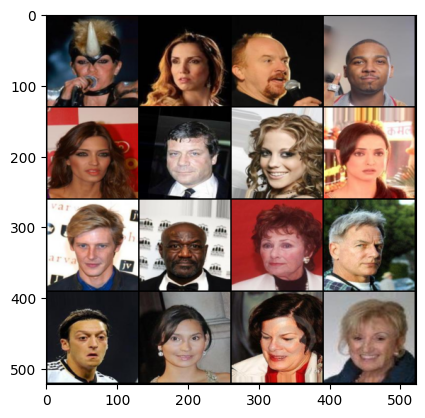

In [ ]:
X , y = next(iter(dataloader))
show_tensor_img(X, 16)

# Gradient Penalty Calculation

In [70]:
def getting_gradient_penalty(real, fake, discriminator, alpha, gama = 10):
  # gama regulates the intensity
  # Linear interpolation - finding mixture of two things: real and fake images
  # alpha is set of random numbers

  mix_images = real * alpha + fake * (1 - alpha) #128x3x128x128
  mix_score = discriminator(mix_images)
  #we pass them through this mis and we obtain the predictions of discriminator 128x1

  gradient = torch.autograd.grad(
      #sum of the gradients of outputs with respect to inputs
      inputs = mix_images,
      outputs = mix_score,
      grad_outputs = torch.ones_like(mix_score),
      #ones same size of scores telling take into account all the gradients and all outputs

      retain_graph = True,
      create_graph = True

  )[0] #we take the first part of the result because this produce 128x3x128x128

  gradient = gradient.view(len(gradient), -1) #128x49152
  gradient_norm = gradient.norm(2, dim = 1)
  """
  the norm of a vector is positive number that expresses its magnitude. It can be called
  different ways. That why you have different types of norm (L1,L2, etc)
  """
  gradient_penalty = ((gradient_norm-1)**2).mean() * gama

  return gradient_penalty

# Saving and Loading Checkpoints

In [71]:
root_path= './data/'
def save_checkpoint(name):
  torch.save({
      'epoch': epoch,
      'model_state_dict': generator.state_dict(),
      'optimizer_state_dict': optimizer_generator.state_dict()
  },f"{root_path}G-{name}.pkl") #pkl format of pythorch

  torch.save({
      'epoch': epoch,
      'model_state_dict': discriminator.state_dict(),
      'optimizer_state_dict': optimizer_discriminator.state_dict()
  },f"{root_path}C-{name}.pkl")

  print("Saved checkpoint")

In [72]:
def load_checkpoint(name):
  checkpoint = torch.load(f"{root_path}G-{name}.pkl")
  generator.load_state_dict(checkpoint['model_state_dict'])
  optimizer_generator.load_state_dict(checkpoint['optimizer_state_dict'])

  checkpoint = torch.load(f"{root_path}C-{name}.pkl")
  discriminator.load_state_dict(checkpoint['model_state_dict'])
  optimizer_discriminator.load_state_dict(checkpoint['optimizer_state_dict'])

  print("Loaded checkpoint")

# Training

In [ ]:
for epoch in range(epochs):
  for real, _ in tqdm(dataloader):
    current_batch_size = len(real) #128
    real = real.to(device)

    #Discriminator
    mean_discriminator_loss = 0
    for _ in range(discriminator_cycles):
      optimizer_discriminator.zero_grad()

      noise = noise_generator(current_batch_size, z_dim)
      fake = generator(noise)
      discriminator_fake_prediction = discriminator(fake.detach())
      # we detach it because we dont want to update the parameters of generator
      discriminator_real_prediction = discriminator(real)

      # Before calculating loss we have to calculate gradient penalty
      alpha = torch.rand(len(real),1,1,1, device = device , requires_grad = True) #128x1x1x1
      gradient_penalty = getting_gradient_penalty(real, fake.detach(), discriminator, alpha)


      #loss
      discriminator_loss = discriminator_fake_prediction.mean() - discriminator_real_prediction.mean() + gradient_penalty
      mean_discriminator_loss += discriminator_loss.item() / discriminator_cycles

      #optimizer
      discriminator_loss.backward(retain_graph = True)

      #optimizer step
      optimizer_discriminator.step()

    #Generator
    optimizer_generator.zero_grad()
    noise = noise_generator(current_batch_size, z_dim)
    fake = generator(noise)
    discriminator_fake_prediction = discriminator(fake)

    generator_loss = -discriminator_fake_prediction.mean()
    generator_loss.backward()
    optimizer_generator.step()

    generator_losses += [generator_loss.item()]

    #stats

    if current_step % save_step == 0 and current_step > 0:
      print("Saving checkpoint: ", current_step, save_step)
      save_checkpoint("latest")

    if current_step % info_step == 0 and current_step >0:
      show_tensor_img(fake, number = 25, name = 'fake')
      show_tensor_img(real, number = 25, name = 'real')

      generator_mean = sum(generator_losses[-info_step:]) /info_step
      discriminator_mean = sum(discriminator_losses[-info_step:]) /info_step
      print(f"Epoch {epoch}, step {current_step}: Generator loss: {generator_mean}, Discriminator loss: {discriminator_mean}")

      plt.plot(
          range(len(generator_losses)),
          torch.Tensor(generator_losses),
          label = 'Generator Loss'
      )

      plt.plot(
          range(len(discriminator_losses)),
          torch.Tensor(discriminator_losses),
          label = 'Discriminator Loss'
      )


      plt.ylim(-1000, 1000)
      """
      ıt would be better to set vertical range smaller. In any case it will be much better
      to see this in the weights and biasses stats panels
      """
      plt.legend()
      plt.show()

    current_step += 1

Output hidden; open in https://colab.research.google.com to view.

Generator loss and critic loss must smaller and closer to each other

# Generate New Faces

In [ ]:
noise = generate_noise(BATCH_SIZE, z_dim)
fake = generator(noise)
show_tensor_img(fake, number = 25)
#showing us 25 fake image

In [ ]:
plt.imshow(fake[4].detach().cpu().permute(1,2,0).squeeze().clip(0,1))
#one big picture

# Morphing


*   Interpolation between points in latent space



In [ ]:
from mpl_toolkits.axes_grid1 import ImageGrid

generator_set=[]
#accumulating different generations of images as we do the interpolation
z_shape = [1,200,1,1]
#batch,size of latent space, typical initial size of generator
rows = 4
steps = 17

for i in range(rows):
  z1,z2 = torch.randn(z_shape), torch.randn(z_shape)
  for alpha in np.linspace(0,1,steps):
    z = alpha*z1 + (1-alpha)*z2
    res = generator(z.cuda())[0]
    #first element of the result to get the image
    generator_set.append(res)
    #we gonna have 17 images of that interpolation

figure = plt.figure(figsize = (25,11))
grid = ImageGrid(figure, 111, nrows_ncols = (rows,steps), axes_padding = 0.1)
#that 111 just for the distribution of the parts of structure of visualization matplotlib

for ax, img in zip (grid,generator_set):
  ax.axis('off')
  res = img.cpu().detach().permute(1,2,0)
  res = res - res.min() #getting rid of the negative values
  res = res/(res.max() - res.min()) #normalizing
  ax.imshow(res)

plt.show()